In [97]:
import gensim
import os
import collections
import smart_open
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import itertools
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
import time
import seaborn as sns
import numpy as np

flatten = lambda l: [item for sublist in l for item in sublist]

In [72]:
"""
Load basic ingredients and compounds data

"""

path = 'data'
ingr_info = path + os.sep + 'ingr_info.tsv'
comp_info = path + os.sep + 'comp_info.tsv'
ingr_comp = path + os.sep + 'ingr_comp.tsv'


# {ingredient_id: [ingredient_name, ingredient_category]}
def load_ingredients(path):
    ingredients = {}
    ingredients_list = []
    with open(path, 'r') as f:
        for line in f:
            if line[0] == '#':
                pass
            else:
                line_split = line.rstrip().split('\t')
                ingredients_id = line_split[0]
                ingredients_list = line_split[1:]
                ingredients[ingredients_id] = ingredients_list
    return ingredients

# {compound_id: [compound_name, CAS_number]}
def load_compounds(path):
    compounds = {}
    compounds_list = []
    with open(path, 'r') as f:
        for line in f:
            if line[0] == '#':
                pass
            else:
                line_split = line.rstrip().split('\t')
                compounds_id = line_split[0]
                compounds_list = line_split[1:]
                compounds[compounds_id] = compounds_list
    return compounds

# {ingredient_id: [compound_id1, compound_id2, ...] }
def load_relations(path):
    relations = {}
    with open(path, 'r') as f:
        for line in f:
            if line[0] == '#':
                pass
            else:
                line_split = line.rstrip().split('\t')
                ingredient_id = line_split[0]
                compound_id = line_split[1]
                
                if ingredient_id in relations:
                    relations[ingredient_id].append(compound_id)
                    
                else:
                    relations[ingredient_id] = [compound_id]
                    
    return relations

ingredients = load_ingredients(ingr_info)
compounds = load_compounds(comp_info)
relations = load_relations(ingr_comp)

def ingredient_to_category(tag, ingredients):
    for ingr_id in ingredients:
        if ingredients[ingr_id][0] == tag:
            return ingredients[ingr_id][1]
        else:
            continue
    return

print ingredient_to_category('copaiba', ingredients)



plant derivative


In [73]:
"""
Load train data and build train_corpus for Doc2Vec

"""
path = 'data'
train_file = path + os.sep + 'ingredient2vec'

def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                line_split = line.split(' ')
                ingredient = line_split[0]
                compounds = ' '.join(line_split[1:])
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(compounds), [ingredient])

# Corpus tag to index
def tag_to_index(tags, corpus):
    for doc_id in range(len(corpus)):
        if tags == corpus[doc_id].tags[0]:
            return doc_id
        else:
            continue
    return
print tag_to_index('ruta_chalepensis_oil', train_corpus)        

# Corpus index to tag                    
def index_to_tag(index, corpus):
    return corpus[index].tags
    
print index_to_tag(0, train_corpus)

train_corpus = list(read_corpus(train_file))
train_corpus[:10]

0
['ruta_chalepensis_oil']


[TaggedDocument(words=[u'nonanone'], tags=['ruta_chalepensis_oil']),
 TaggedDocument(words=[u'butyl_butyrate'], tags=['passiflora_mollissima']),
 TaggedDocument(words=[u'thymol', u'octanone', u'pentylfuran', u'nerolidol', u'myrcene', u'formyl', u'ene', u'isopulegol', u'salicylaldehyde', u'mentha', u'dien', u'ol', u'octanal', u'methylanisole', u'veratraldehyde'], tags=['mastic_gum_oil']),
 TaggedDocument(words=[u'benzyl_alcohol'], tags=['copaiba']),
 TaggedDocument(words=[u'bornyl_acetate', u'isoamyl_alcohol'], tags=['teucrium_chamaedrys']),
 TaggedDocument(words=[u'menth', u'ene', u'al', u'piperitone', u'formyl', u'ene'], tags=['seed_oil']),
 TaggedDocument(words=[u'taurine'], tags=['octopus']),
 TaggedDocument(words=[u'phenyl', u'propanol'], tags=['storax']),
 TaggedDocument(words=[u'trimethyl', u'cyclohexa', u'dienyl', u'but', u'en', u'one'], tags=['summer_savory']),
 TaggedDocument(words=[u'diacetyl'], tags=['fagroea_racemosa_flower'])]

In [95]:
# Prettify ingredients
pretty_food = lambda s: ' '.join(s.split('_')).capitalize().lstrip()
# Prettify cuisine names
pretty_category = lambda s: ''.join(map(lambda x: x if x.islower() else " "+x, s)).lstrip()


def make_plot(name, points, labels, legend_labels, legend_order, legend_label_to_color, pretty_legend_label, publish):
    lst = zip(points, labels, legend_labels)
    full = sorted(lst, key=lambda x: x[2])
    traces = []
    for legend_label, group in itertools.groupby(full, lambda x: x[2]):
        group_points = []
        group_labels = []
        for tup in group:
            point, label, _ = tup
            group_points.append(point)
            group_labels.append(label)
        group_points = np.stack(group_points)
        traces.append(go.Scattergl(
            x = group_points[:, 0],
            y = group_points[:, 1],
            mode = 'markers',
            marker = dict(
                color = legend_label_to_color[legend_label],
                size = 8,
                opacity = 0.6,
                #line = dict(width = 1)
            ),
            text = ['{} ({})'.format(label, pretty_legend_label(legend_label)) for label in group_labels],
            hoverinfo = 'text',
            name = legend_label
        )
        )
    # order the legend
    ordered = [[trace for trace in traces if trace.name == lab] for lab in legend_order]
    traces_ordered = flatten(ordered)
    def _set_name(trace):
        trace.name = pretty_legend_label(trace.name)
        return trace
    traces_ordered = list(map(_set_name, traces_ordered))
    layout = go.Layout(
        xaxis=dict(
            autorange=True,
            showgrid=False,
            zeroline=False,
            showline=False,
            autotick=True,
            ticks='',
            showticklabels=False
        ),
        yaxis=dict(
            autorange=True,
            showgrid=False,
            zeroline=False,
            showline=False,
            autotick=True,
            ticks='',
            showticklabels=False
        )
    )
    fig = go.Figure(data=traces_ordered, layout=layout)
    if publish:
        plotter = py.iplot
    else:
        plotter = offline.plot
    plotter(fig, filename=name + '.html')

In [3]:
"""
Train Doc2Vec Model

"""

#dm/m,d50,n5,w5,mc5,s0.001,t3
model = gensim.models.doc2vec.Doc2Vec(size=50, min_count=20, iter=55)
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

CPU times: user 39 s, sys: 2min 3s, total: 2min 42s
Wall time: 8.29 s


1366001

In [19]:
"""
Check rank of inferred_vector

"""

ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(train_corpus[doc_id].tags[0])
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [5]:
"""
Pick a random document from the test corpus and infer a vector from the model
Top 10 Similar Vector

"""
doc_id = random.randint(0, len(train_corpus))

print('Train Document ({}, {}): [{}]\n'.format(doc_id, train_corpus[doc_id].tags[0], ' '.join(train_corpus[doc_id].words)))

inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=10)
for sim in sims:
    print sim

Train Document (617, callitris): [geranyl_acetate]

('lime_oil', 0.8372728228569031)
('japanese_seafood', 0.8265045285224915)
('smoke', 0.8218311071395874)
('litsea_citrata', 0.8216601014137268)
('storax', 0.8183588981628418)
('melissa_oil', 0.8174795508384705)
('grapefruit_peel', 0.814770519733429)
('calyptranthes_parriculata', 0.8145121932029724)
('galbanum_oil', 0.8144044876098633)
('eucalyptus_radiata_oil', 0.8127471208572388)


In [71]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus))
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Train Document ({}, {}): [{}]\n'.format(doc_id, train_corpus[doc_id].tags[0], ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print label, sims[index]
    #print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Train Document (1267, petrosimonia_monandra): [piperidine]

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc20,s0.001,t3):

MOST ('oxidized_milk', 0.8705099821090698)
MEDIAN ('seed', 0.5615507364273071)
LEAST ('bergamot_peel_oil', -0.44836682081222534)


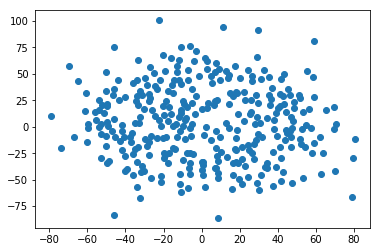

In [29]:
"""
word-level plotting

""" 
X = model[model.wv.vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [78]:
"""
TSNE of Doc2Vec

"""
time_start = time.time()
X = model.docvecs
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

t-SNE done! Time elapsed: 11.2963461876 seconds


In [102]:
labels = []
categories = []

for doc_id in range(0, len(model.docvecs)):
    labels.append(model.docvecs.index_to_doctag(doc_id))

for label in labels:
    categories.append(ingredient_to_category(label,ingredients))

categories_color = list(set(categories))
print categories_color

category2color = {
    'plant' :  sns.xkcd_rgb["grey"],
    'flower' : sns.xkcd_rgb["forest green"],
    'meat' : sns.xkcd_rgb["light pink"],
    'nut/seed/pulse' : sns.xkcd_rgb["mustard yellow"],
    'herb' : sns.xkcd_rgb["orange"],
    'alcoholic beverage' : sns.xkcd_rgb["magenta"],
    'plant derivative' : sns.xkcd_rgb["purple"],
    'fruit' : sns.xkcd_rgb["blue"],
    'dairy' : sns.xkcd_rgb["deep blue"],
    'cereal/crop' : sns.xkcd_rgb["sky blue"],
    'vegetable' : sns.xkcd_rgb["olive"],
    'animal product' : sns.xkcd_rgb["red"],
    'fish/seafood' : sns.xkcd_rgb["yellow"],
    'spice' : sns.xkcd_rgb["black"],
}

category_order = [
'plant',
'flower',
'meat',
'nut/seed/pulse',
'herb',
'alcoholic beverage',
'plant derivative',
'fruit',
'dairy',
'cereal/crop',
'vegetable',
'animal product',
'fish/seafood',
'spice',
]

['plant', 'flower', 'meat', 'nut/seed/pulse', 'herb', 'alcoholic beverage', 'plant derivative', 'fruit', 'dairy', 'cereal/crop', 'vegetable', 'animal product', 'fish/seafood', 'spice']


In [103]:
make_plot(name='food2vec_food_embeddings_tsne',
          points=X_tsne, 
          labels=labels, 
          legend_labels=categories, 
          legend_order=category_order, 
          legend_label_to_color=category2color, 
          pretty_legend_label=pretty_category,
          publish=False)

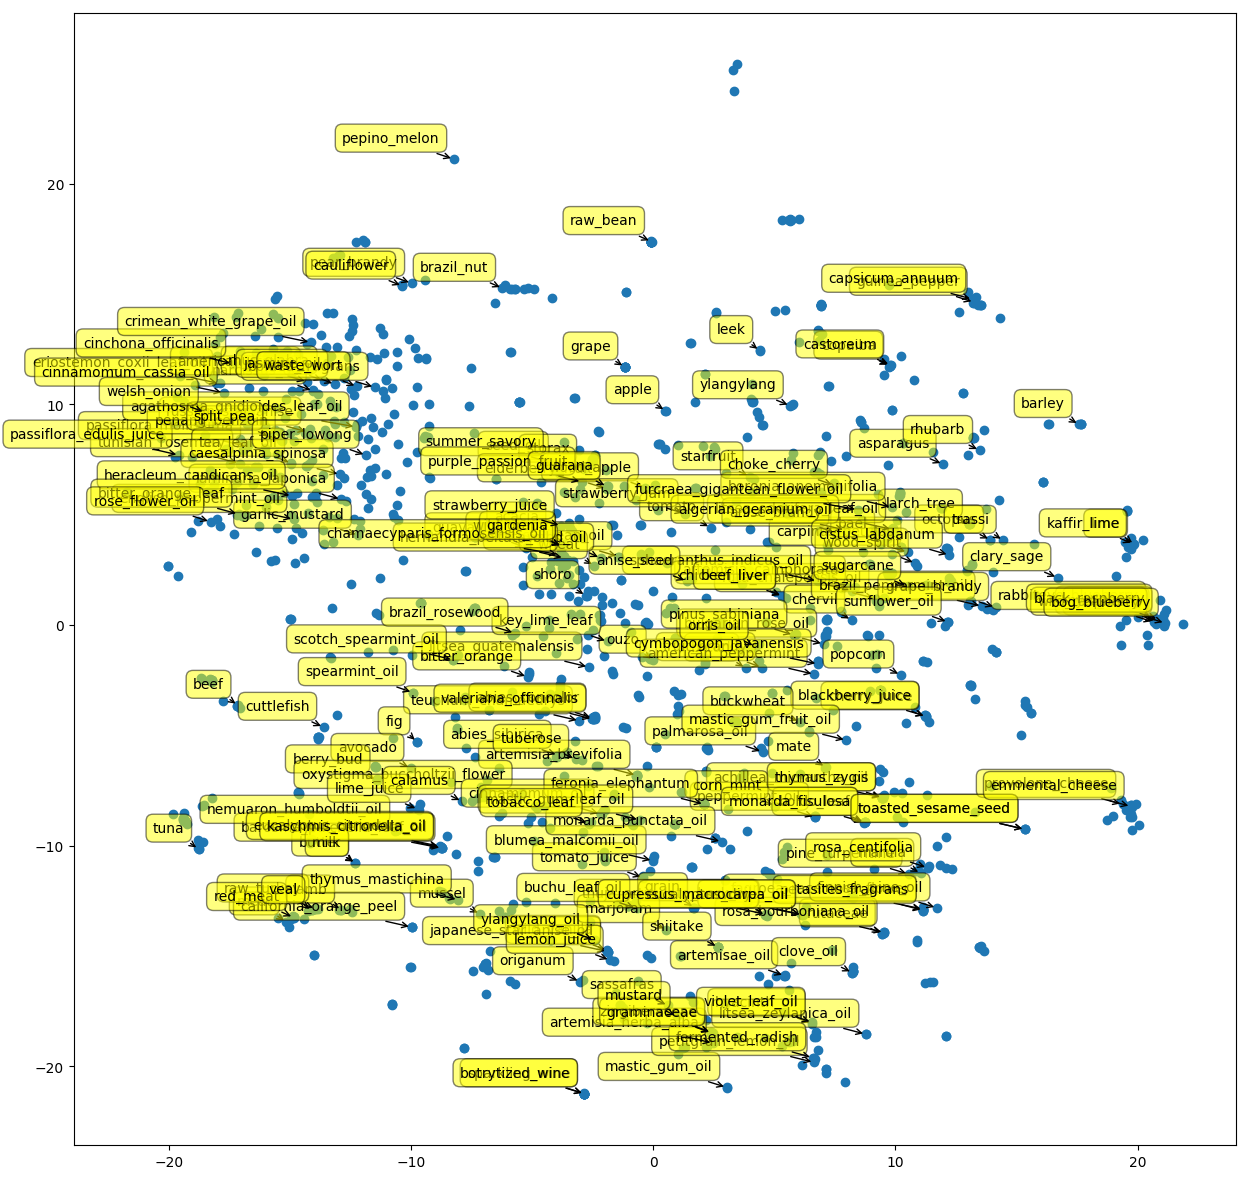

In [84]:
"""
ingredient-level plotting
"""
#define plot size in inches (width, height) & resolution(DPI)
fig = plt.figure(figsize=(15, 15), dpi=100)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

for label, x, y in zip(labels[:200], X_tsne[:, 0][:200], X_tsne[:, 1][:200]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.show()


In [10]:
for i in model.docvecs.indexed_doctags('butter'):
    print i

[]
[[-0.12280162 -0.00451311  0.12690473 ...,  0.06876533 -0.05695188
  -0.17338629]
 [-0.00664265 -0.00622044  0.00451518 ...,  0.00873413  0.00263543
   0.00867833]
 [-0.06617593  0.33063376 -0.19838455 ..., -0.11592285  0.05416442
   0.0115643 ]
 ..., 
 [-0.09835157 -0.07525922  0.10597777 ...,  0.06786586  0.06802031
  -0.2348375 ]
 [-0.27128252 -0.09118522  0.20158942 ...,  0.12255996  0.02811879
  -0.4951013 ]
 [-0.00102201  0.00339739 -0.00154178 ...,  0.00459677  0.006519
   0.00416949]]
[ 1.  1.  1. ...,  1.  1.  1.]
butter


In [59]:
# Pick a random document from the test corpus and infer a vector from the model

doc_id = random.randint(0, len(train_corpus))

inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Train Document ({}, {}): [{}]\n'.format(doc_id, train_corpus[doc_id].tags[0], ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print label, sims[index]
    #print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))


Train Document (169, cupressus_macrocarpa_oil): [carvomenthenol]

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc20,s0.001,t3):

MOST ('hatsutake', 0.8876945376396179)
MEDIAN ('rhus_cotinus_leaf', 0.5743974447250366)
LEAST ('macadamia_nut', -0.5380587577819824)


In [54]:
# ingredient-level
X = model.docvecs

for i in range(0, len(model.docvecs)):
    labels.append(model.docvecs.index_to_doctag(i))
    
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [52]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline

# Create random data with numpy
import numpy as np

labels = []
for i in range(0, len(model.docvecs)):
    labels.append(model.docvecs.index_to_doctag(i))
   
# Create a trace
trace = go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    ),
    text = labels
)

data = [trace]

# Plot and embed in ipython notebook!
#offline.plot(data, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')

'file:///Users/asd/coding/ingredient2vec/basic-scatter.html'